In [1]:
# !pip install hypernetx ## uncomment to run in Colab

# A Hypergraph Analysis of the novel Les Miserables  by Victor Hugo  

<img src="../images/LesMisStudyOpeningGraphic.png" >

As readers, we are mesmerized by the prose and drama and are horrified by the meanness of the time. But as mathematicians, we delight in the opportunity to study the relationships among the characters and discover what the hypergraphs they generate tell us about the story. We use the data available from the [Stanford GraphBase]( https://www-cs-faculty.stanford.edu/~knuth/sgb.html).

In [2]:
import hypernetx as hnx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools as itt
import warnings 
warnings.simplefilter('ignore')

from collections import defaultdict

In [3]:
lm = hnx.LesMis()

### Basic Structure of the Novel
The novel is broken into five parts, which we will here reference as volumes: **Fantine**, **Cosette**, **Marius**, **St. Denis**, and **Jean Valjean**. Each volume is subdivided into books, each book into chapters, and each chapter into scenes. By shifting the level of subdivision, we are able to construct multiple hypergraphs modeling character interactions and relationships.

In [4]:
volumes = lm.volumes
volumes

,title
1,Fantine
2,Cosette
3,Marius
4,St. Denis
5,Jean Valjean


In [5]:
### List of Characters
names = lm.df_names.set_index('Symbol')
names

,FullName,Description
Symbol,,
AZ,Anzelma,daughter of TH and TM
BA,Bahorel,`Friends of the ABC' cutup
BB,Babet,tooth-pulling bandit of Paris
BJ,Brujon,notorious criminal
BL,Blacheville,Parisian student from Montauban
...,...,...
TS,Toussaint,servant of JV at Rue Plumet
VI,Madame Victurnien,snoop in M-- sur M--
XA,Child 1,son of TH sold to MN


In [6]:
### Who are the characters?
lm.df_names

,Symbol,FullName,Description
0,AZ,Anzelma,daughter of TH and TM
1,BA,Bahorel,`Friends of the ABC' cutup
2,BB,Babet,tooth-pulling bandit of Paris
3,BJ,Brujon,notorious criminal
4,BL,Blacheville,Parisian student from Montauban
...,...,...,...
75,TS,Toussaint,servant of JV at Rue Plumet
76,VI,Madame Victurnien,snoop in M-- sur M--
77,XA,Child 1,son of TH sold to MN
78,XB,Child 2,son of TH sold to MN


In [7]:
### List of Characters as they appear in each scene
scenes = lm.df_scenes;scenes

,Volume,Book,Chapter,Scene,Step,Characters
0,1,1,1,0,0,MY
1,1,1,1,0,0,NP
2,1,1,1,1,1,MY
3,1,1,1,1,1,MB
4,1,1,2,0,2,MY
...,...,...,...,...,...,...
857,5,9,4,1,400,MA
858,5,9,4,1,400,CO
859,5,9,5,0,401,JV
860,5,9,5,0,401,CO


In [8]:
h = hnx.Hypergraph(scenes,
                  edge_col='Volume',
                  node_col = 'Characters',
                  node_properties = lm.df_names)

In [9]:
h.dataframe

,edges,nodes,weight,Book,Chapter,Scene,Step,misc_properties
0,1,MY,1,1,1,0,0,{}
1,1,NP,1,1,1,0,0,{}
2,1,MB,1,1,1,1,1,{}
3,1,ME,1,1,2,0,2,{}
4,1,CL,1,1,4,1,6,{}
...,...,...,...,...,...,...,...,...
137,5,TH,1,3,3,0,364,{}
138,5,GI,1,3,12,0,373,{}
139,5,BZ,1,5,1,0,375,{}
140,5,MG,1,5,4,0,378,{}


## Hypergraph with each Volume as an Edge

We first generate a hypergraph studying the relationship between volumes.  The edges are the volumes and the characters who appear in each volume are the nodes. 

In [10]:
### Construct the edges as a dictionary named by the name of the Volume
volume_edges = {v : set(scenes.loc[scenes.Volume == v]['Characters']) for v in range(1, 6)}

### Construct a hypergraph made up of volume_edges
HV = hnx.Hypergraph(volume_edges,name='Volumes')
for node in HV.nodes:
    HV.nodes[node].name = names.loc[node]['FullName']
    HV.nodes[node].description = names.loc[node]['Description']

In [11]:
## What is in an edge?
HV.edges[1]

AttrList(['SC',
          'JL',
          'VI',
          'ZE',
          'FT',
          'DA',
          'CV',
          'SP',
          'MY',
          'GE',
          'PG',
          'NP',
          'FF',
          'CH',
          'SN',
          'CN',
          'TH',
          'FN',
          'BL',
          'BM',
          'BR',
          'MC',
          'JV',
          'CO',
          'IS',
          'MR',
          'FA',
          'PO',
          'JU',
          'MB',
          'ME',
          'CL',
          'SS',
          'LI',
          'FV',
          'MT',
          'JA',
          'TM',
          'GG',
          'CC'])

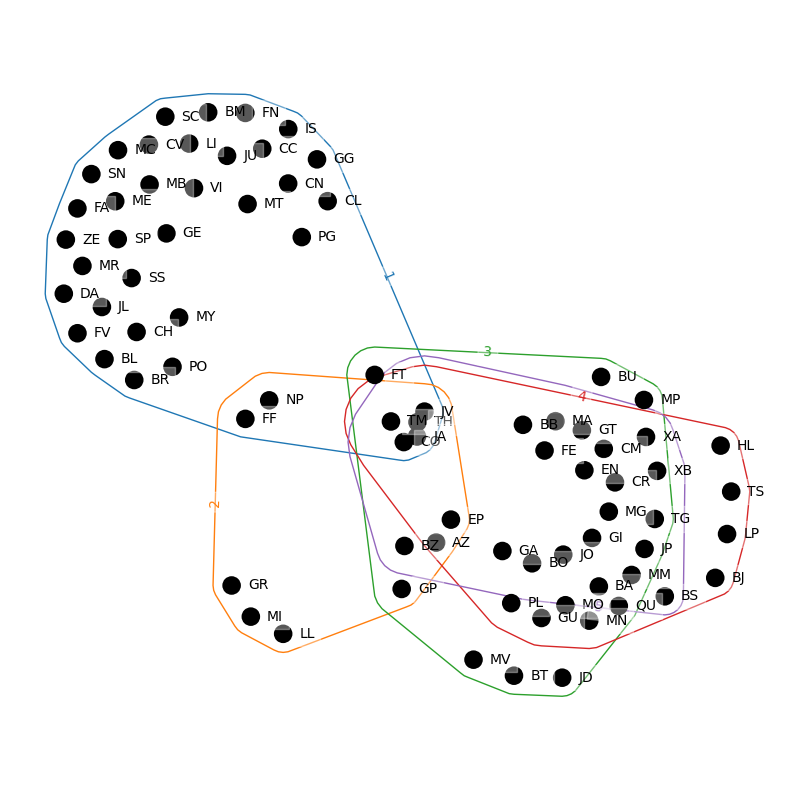

In [12]:
plt.figure(figsize=[10,10])
hnx.draw(HV)

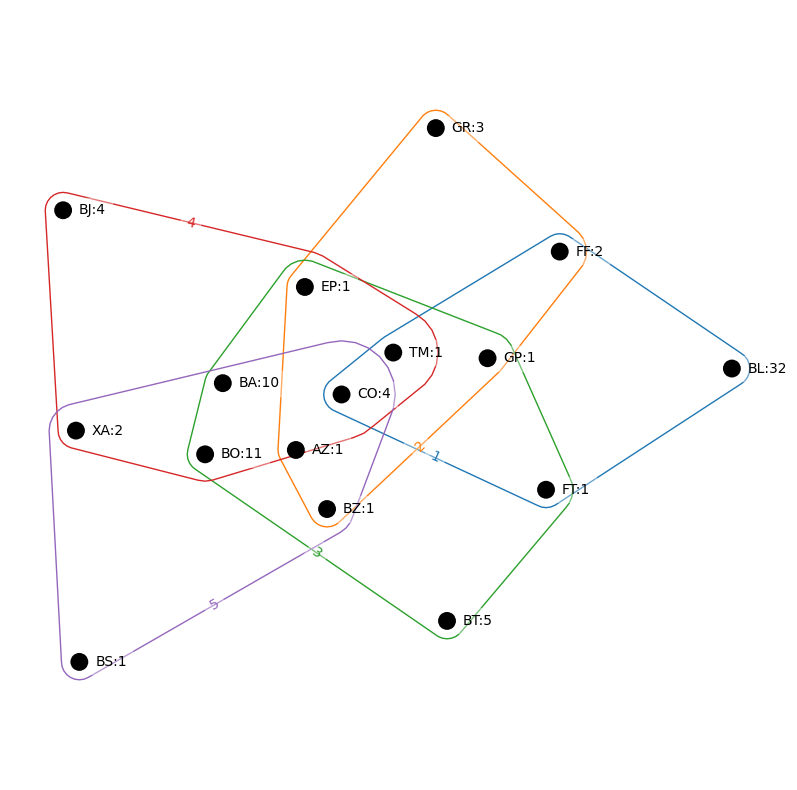

In [13]:
### Collapse the nodes to understand the relationships (same as diagram in title)
plt.figure(figsize=[10,10])
hnx.draw(HV.collapse_nodes(use_counts=True))

Noting the characters in the intersections between edges gives a sense of their importance. Which characters are central to the novel?

In [14]:
### Who are the four characters belonging to all five volumes?
volume_char_sets = list(set(HV.edges[idx]) for idx in range(1,6))
core_characters = list(set.intersection(*volume_char_sets))
names.loc[core_characters]

,FullName,Description
Symbol,,
JV,Jean Valjean,thief of bread
JA,Javert,police officer of M-- sur M--
TH,Th\'enardier,sergeant of Waterloo and keeper of a chophouse
CO,Cosette,daughter of FN and FT


In [15]:
### Who are the characters belonging to the different intersections? 
## Replace the values in the array with the volumes of interest.
vols = [3,4]
volume_char_sets = list(set(HV.edges[idx]) for idx in vols)
chars_of_interest = list(set.intersection(*volume_char_sets))
names.loc[chars_of_interest]


,FullName,Description
Symbol,,
FE,Feuilly,`Friends of the ABC' political idealist
MO,Montparnasse,genteel bandit of Paris
GA,Gavroche,young urchin living at Gorbeau House
MA,Marius,grandson of GI
JP,Jean Prouvaire,`Friends of the ABC' poet
EN,Enjolras,`Friends of the ABC' chief
TH,Th\'enardier,sergeant of Waterloo and keeper of a chophouse
BB,Babet,tooth-pulling bandit of Paris
MM,Monsieur Mabeuf,prefect of church


In [16]:
## What are the intersection sizes:
volume_intersections = dict()
for pair in itt.combinations(range(1,6),2):
    volume_char_sets = list(set(HV.edges[idx]) for idx in pair)
    titlepair = (volumes.title[pair[0]],volumes.title[pair[1]])
    volume_intersections[tuple(pair)] = len(set.intersection(*volume_char_sets))
print("Number of Characters shared by pairs of volumes:")
pd.DataFrame.from_dict(volume_intersections,orient="index")

Number of Characters shared by pairs of volumes:


,0
"(1, 2)",7
"(1, 3)",6
"(1, 4)",5
"(1, 5)",4
"(2, 3)",8
"(2, 4)",6
"(2, 5)",6
"(3, 4)",27
"(3, 5)",16
"(4, 5)",17


### Highlights from each Volume (A very very very short description...)

Fantine: Volume 1 Lays the foundation for the novel. Most of the characters do not appear in subsequent volumes. Most important of these is Fantine. As mother of Cosette, she sacrifices her life in the support of her daughter and lays the charge on Jean Valjean to care for Cosette when she dies.  In contrast to Fantine, Jean Valjean and Cosette appear in all the volumes. A central story to the novel follows their travels as they flee from the relentless pursuit by Javert and the dogged and often comical abuses of Thenardier. Jean Valjean, originally convicted for stealing bread, begins as a hardened convict but through the mercy of a bishop is transformed into a philanthropist.

Cosette: Volume 2 follows Cosette's liberation from her caretakers, the Thenardiers, by Jean Valjean. They flee into hiding from Javert and find refuge in a convent, where Valjean works as a gardener and Cosette is educated. Much character development is done, including a long description of Waterloo ending with the singular way in which M. Thenardier obtained a silver cross of the Legion of Honour while saving the life of one Pontmercy.

Marius: Marius Pontmercy, son of an officer in Napoleon's army and grandson of a Royalist, experiences conflicting loyalties and ultimately turns his back on friends and family and lives among the poor. He sees and eventually falls in love with Cosette. In honor of his father, he attempts to help M. Thenardier but discovers his treachery when M. Thenardier attempts to murder the person he takes to be Cosette's father.

St. Denis: With his love for Cosette thwarted, Marius joins a group of students to participate in an uprising known as the June rebellion. They construct a barricade near the Rue Saint-Denis.

Jean Valjean: Jean Valjean saves Marius's life when soldiers overwhelm the barricades. Marius discovers Jean Valjean's true identity from Thenardier. Jean Valjean dies at peace with Cosette and Marius.



## Hypergraph of each Volume using Books as edges. 


In [17]:
### Construct a hypergraph for each volume
### The edges will be the books and the nodes the characters.
fantine = scenes.loc[scenes.Volume == 1]
cosette = scenes.loc[scenes.Volume == 2]
marius = scenes.loc[scenes.Volume == 3]
stdenis = scenes.loc[scenes.Volume == 4]
jeanvaljean = scenes.loc[scenes.Volume == 5]

In [18]:
### Construct the edges as a dictionaries
vols = [0,fantine, cosette, marius, stdenis, jeanvaljean]
HB = dict()
for idx in range(1,6):
    book_edges = dict()
    for book in vols[idx].Book:
        book_edges[book] = set(vols[idx].loc[vols[idx].Book == book]['Characters'])
    ### Construct a hypergraph made up of volume_edges
    HB[idx] = hnx.Hypergraph(book_edges,name=f"{volumes.title[idx]}-Books")
    for node in HB[idx].nodes:
        HB[idx].nodes[node].name = names.loc[node]['FullName']
        HB[idx].nodes[node].description = names.loc[node]['Description']

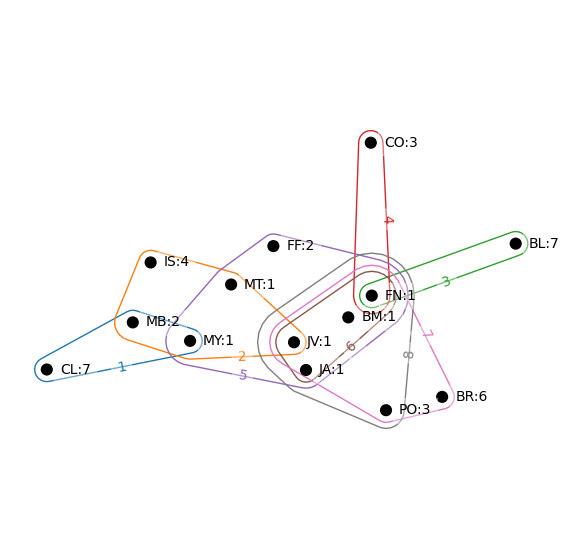

In [19]:
plt.figure(figsize=[7,7])
hnx.draw(HB[1].collapse_nodes(use_counts=True))

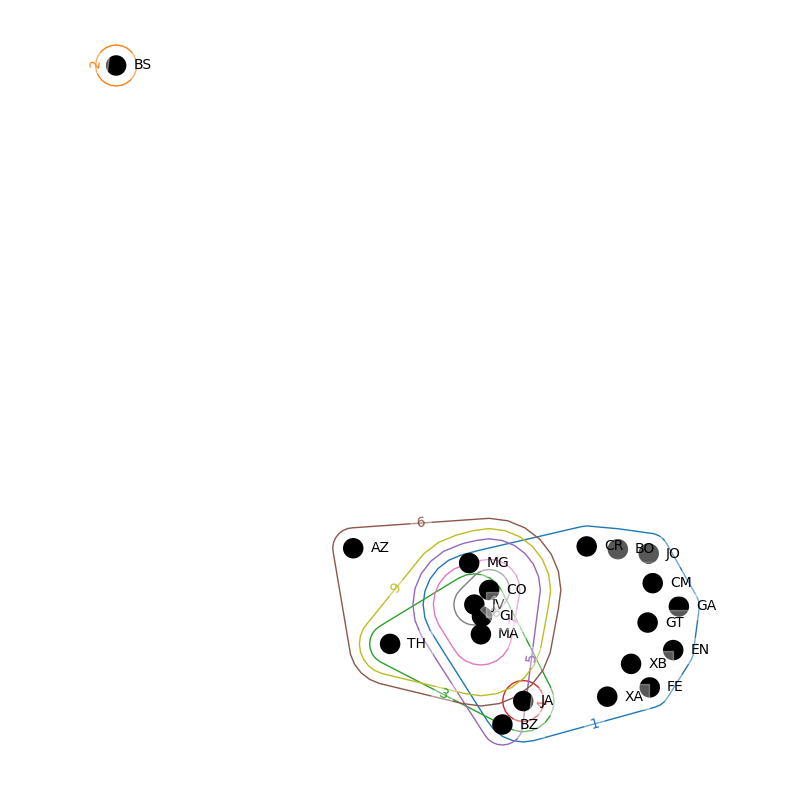

In [20]:
### In the final book there is a long section on the Paris Sewers. 
### The only character in that section was the creator of the sewers.
plt.figure(figsize=[10,10])
hnx.draw(HB[5])

In [21]:
HB[5].nodes['BZ']

AttrList([5])

In [22]:
HB[5].nodes.memberships['BZ'] ## Bruneseau belongs to the 2nd book in volume 5

[5]

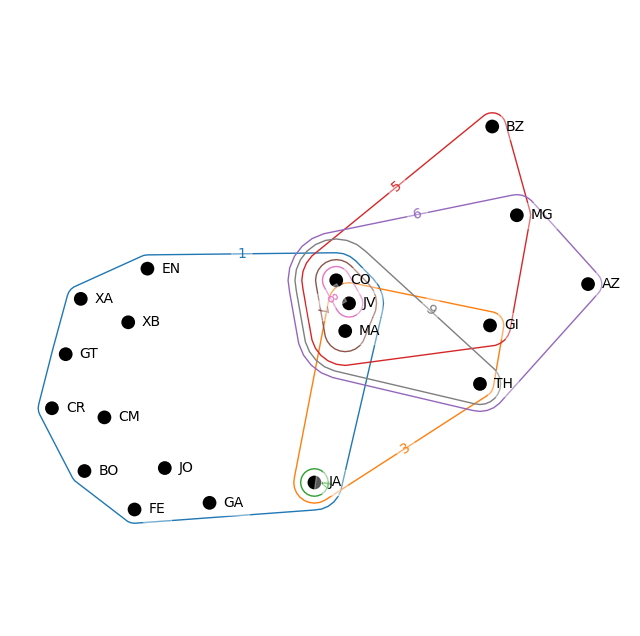

In [23]:
### Separate the components and consider the large one
c1,c2 = list(HB[5].component_subgraphs(return_singletons=True))
hnx.draw(c1)

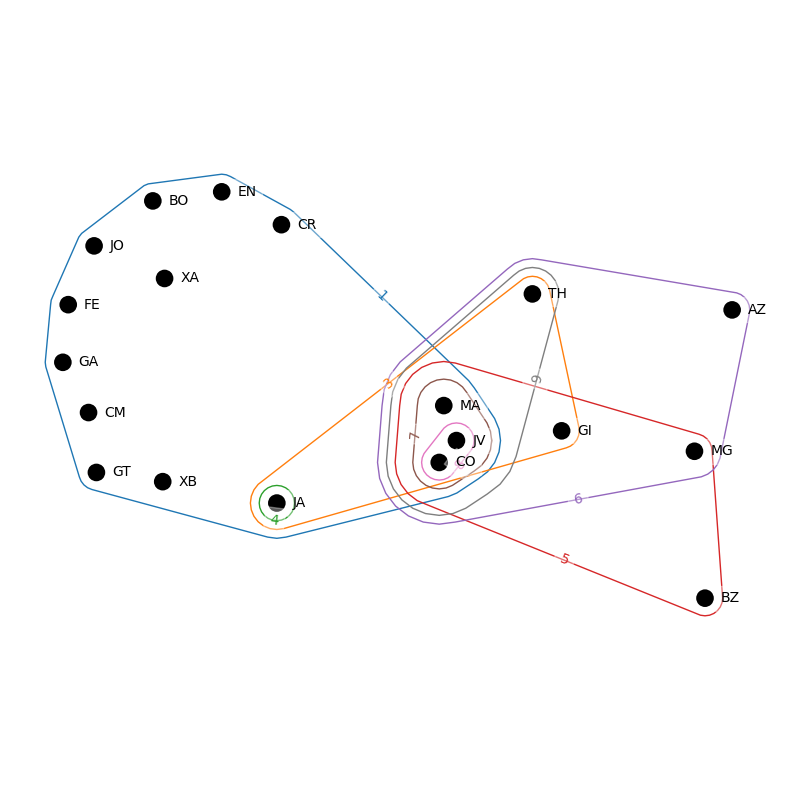

In [24]:
### Note in the first book of this volume the soldiers confront the students at the barricades
### Most of the students are killed
### In the 4th book Javert dies alone
### At the center, in the last scene (8), there is only JV and CO
plt.figure(figsize=[10,10])
hnx.draw(c1)

In [25]:
HB[5].edges.items

{1, 2, 3, 4, 5, 6, 7, 8, 9}

## Who knew who?

We can examine the interactions between certain characters by studying their neighborhoods and induced subgraphs.


In [26]:
## In Volume 1, Restrict to the nodes in a neighborhood of Fantine 
## and construct the subhypergraph of HB[1] restricted to these nodes 

FNnodes = list(HB[1]['FN'])
FNnodes.append('FN')
FNNeighborhood = HB[1].restrict_to_nodes(FNnodes)

In [27]:
FNNeighborhood.incidence_dict

{1: ['MY'],
 2: ['MT', 'MY', 'JV'],
 3: ['LI', 'FV', 'FN', 'FT', 'ZE', 'BL', 'DA', 'FA'],
 4: ['TM', 'TH', 'FN', 'CO'],
 5: ['MT', 'FN', 'VI', 'BM', 'MY', 'JA', 'JV', 'FF'],
 6: ['JV', 'JA', 'FN'],
 7: ['SC', 'CN', 'SS', 'FN', 'BM', 'BR', 'SP', 'JV', 'PO', 'JU', 'CC', 'CH'],
 8: ['SS', 'FN', 'SP', 'JA', 'PO', 'JV']}

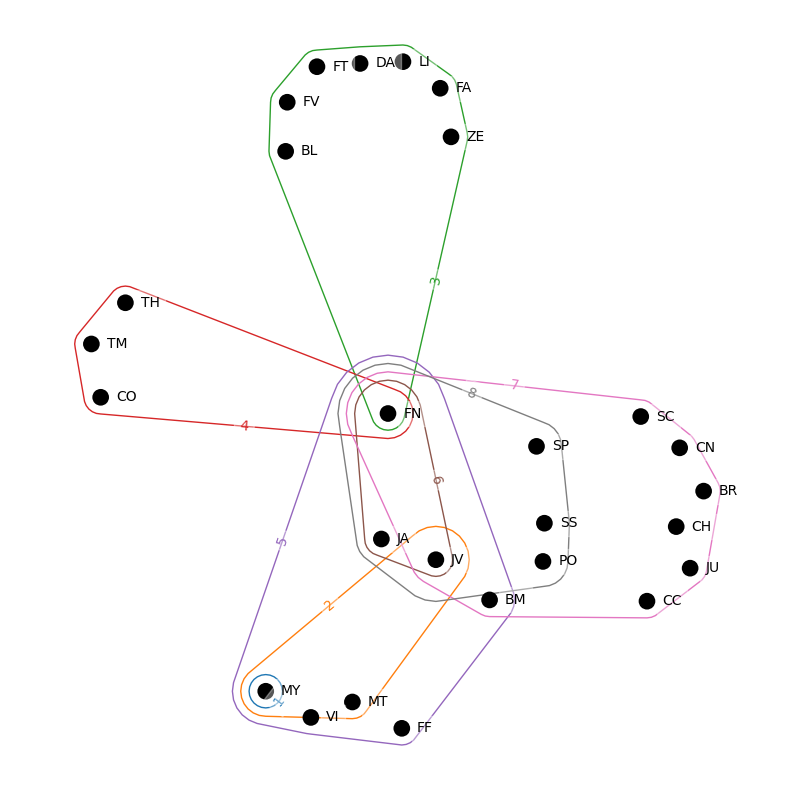

In [28]:
plt.figure(figsize=[10,10])
hnx.draw(FNNeighborhood)

In [29]:
## In Volume 1, Restrict to a neighborhood of Jean Valjean
JVnodes = list(HB[1]['JV'])
JVnodes.append('JV')
JVNeighborhood = HB[1].restrict_to_nodes(JVnodes)
JVNeighborhood.incidence_dict

{1: ['MY', 'MB', 'ME'],
 2: ['IS', 'MT', 'JL', 'MR', 'MY', 'PG', 'JV', 'MB', 'ME'],
 3: ['FN'],
 4: ['FN'],
 5: ['MT', 'FN', 'VI', 'BM', 'MY', 'JA', 'JV', 'FF'],
 6: ['JV', 'JA', 'FN'],
 7: ['SC', 'CN', 'SS', 'FN', 'BM', 'BR', 'SP', 'JV', 'PO', 'JU', 'CC', 'CH'],
 8: ['SS', 'FN', 'SP', 'JA', 'PO', 'JV']}

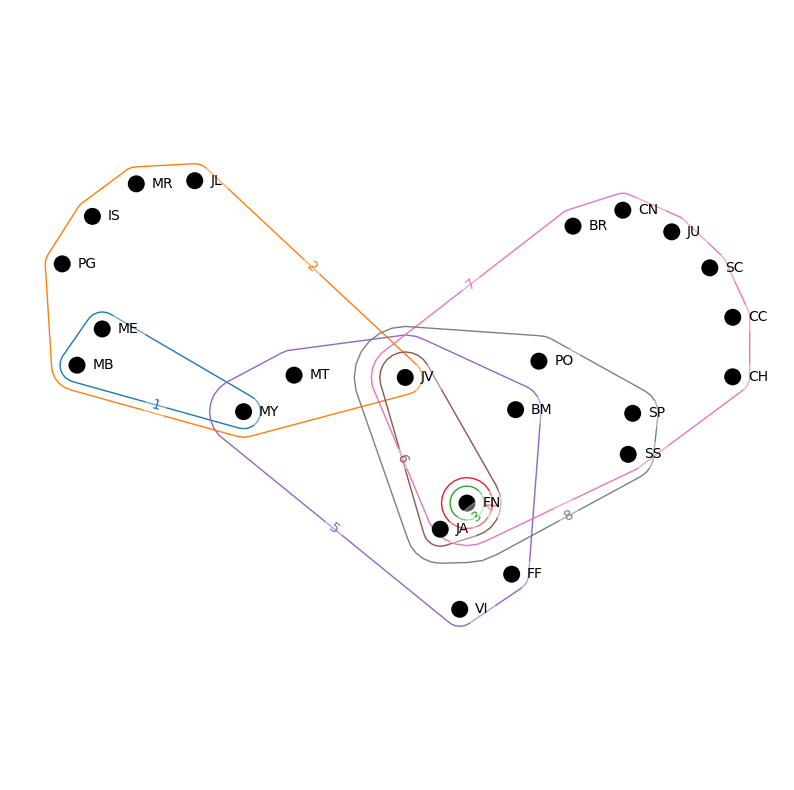

In [30]:
plt.figure(figsize=[10,10])
hnx.draw(JVNeighborhood)

In [31]:
## Combine the subgraphs
Fantine_edges = list(FNNeighborhood.edges.elements.values())
JVFNHypergraph = HB[1].restrict_to_nodes(JVnodes)

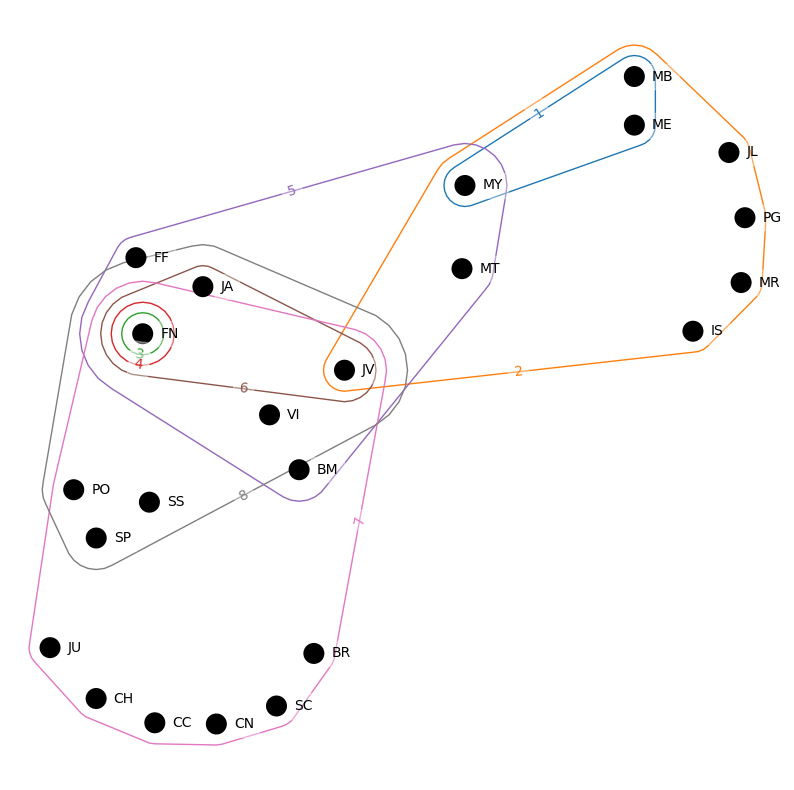

In [32]:
plt.figure(figsize=[10,10])
hnx.draw(JVFNHypergraph)

## Hypergraph of each Volume using scenes as edges

In [33]:
## Scene hypergraphs for each Volume indexed by Book,Chapter,Scene.
vols = [0,fantine, cosette, marius, stdenis, jeanvaljean]
scene_edges = defaultdict(list)
HS = dict()
for idx in range(1,6):
    scene_edges = defaultdict(list)
    for row in vols[idx].itertuples():
        scene_edges[f"{row.Book}.{row.Chapter}.{row.Scene}"].append(row.Characters)
    ### Construct a hypergraph made up of scene_edges
    HS[idx] = hnx.Hypergraph(scene_edges,name=f"{volumes.title[idx]}-Scenes")
    for node in HS[idx].nodes:
        HS[idx].nodes[node].name = names.loc[node]['FullName']
        HS[idx].nodes[node].description = names.loc[node]['Description']    

In [34]:
HS[1].edges.incidence_dict

{'1.1.0': ['MY', 'NP'],
 '1.1.1': ['MY', 'MB'],
 '1.10.0': ['MY', 'GG'],
 '1.11.0': ['MY'],
 '1.12.0': ['MY'],
 '1.13.0': ['MY'],
 '1.14.0': ['MY', 'SN'],
 '1.2.0': ['MY', 'ME'],
 '1.2.1': ['ME', 'MB'],
 '1.3.0': ['MY'],
 '1.4.0': ['MY', 'ME'],
 '1.4.1': ['MY', 'CL'],
 '1.4.2': ['MY', 'GE'],
 '1.4.3': ['MY', 'MC'],
 '1.4.4': ['MY', 'MB'],
 '1.5.0': ['MY', 'MB', 'ME'],
 '1.6.0': ['ME', 'MY'],
 '1.7.0': ['MY', 'CV'],
 '1.7.1': ['MY', 'MB', 'ME'],
 '1.8.0': ['SN', 'MY'],
 '1.9.0': ['MB'],
 '2.1.0': ['JL', 'JV'],
 '2.1.1': ['JV', 'MT'],
 '2.1.2': ['MR', 'JV'],
 '2.10.0': ['JV'],
 '2.11.0': ['JV'],
 '2.12.0': ['MY', 'ME'],
 '2.12.1': ['MY', 'JV'],
 '2.13.0': ['PG', 'JV'],
 '2.2.0': ['ME', 'MB', 'MY'],
 '2.3.0': ['ME', 'MB', 'MY', 'JV'],
 '2.4.0': ['MY', 'JV', 'MB'],
 '2.4.1': ['MY', 'JV', 'MB', 'ME'],
 '2.5.0': ['MY', 'ME', 'JV'],
 '2.6.0': ['JV', 'IS'],
 '2.7.0': ['JV'],
 '2.9.0': ['JV'],
 '3.2.0': ['FT', 'LI', 'FA', 'BL'],
 '3.3.0': ['FT', 'LI', 'FA', 'BL', 'FV', 'DA', 'ZE', 'FN'],
 '3.4.

## Who knew who by Scenes?

### Difference in relationships when drilling down into hierarchy of sets

We consider the neighborhoods of Fantine and Jean Valjean in the Scenes hypergraph. 
Starting with the subgraph generated by the neighbors of Fantine, we restrict to neighbors of Jean Valjean.

In [35]:
## In Volume 1, Restrict to a neighborhood of Fantine
FNnodes = list(HS[1]['FN'])
FNnodes.append('FN')
FNNeighborhood = HS[1].restrict_to_nodes(FNnodes)
jvfn = list(FNNeighborhood['JV'])
jvfn.append('JV')
FNJVNeighborhood = FNNeighborhood.restrict_to_nodes(jvfn)

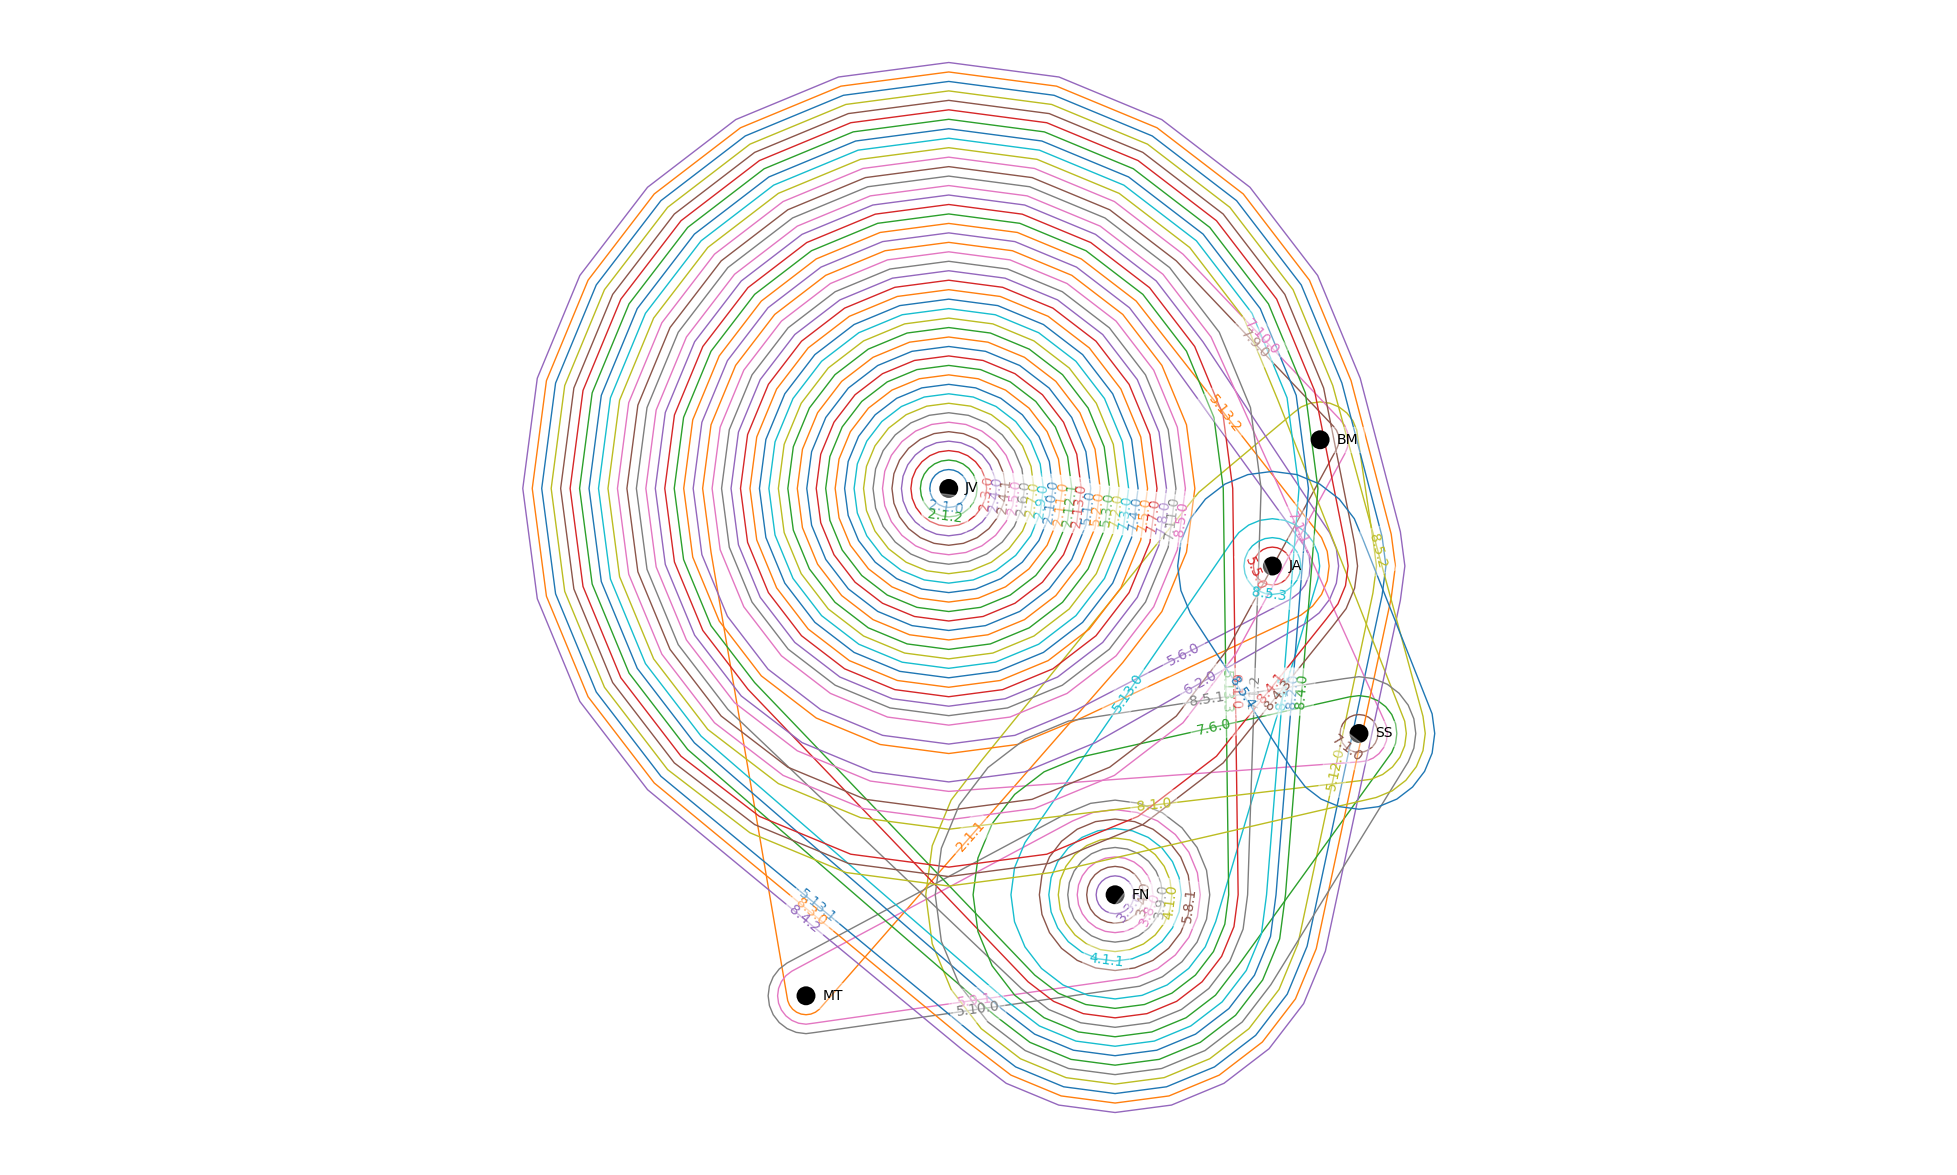

In [36]:
plt.figure(figsize=[25,15])
hnx.draw(FNJVNeighborhood)

While the graph shows FN and JV as central points we can more clearly visualize the core relationships by collapsing the edges

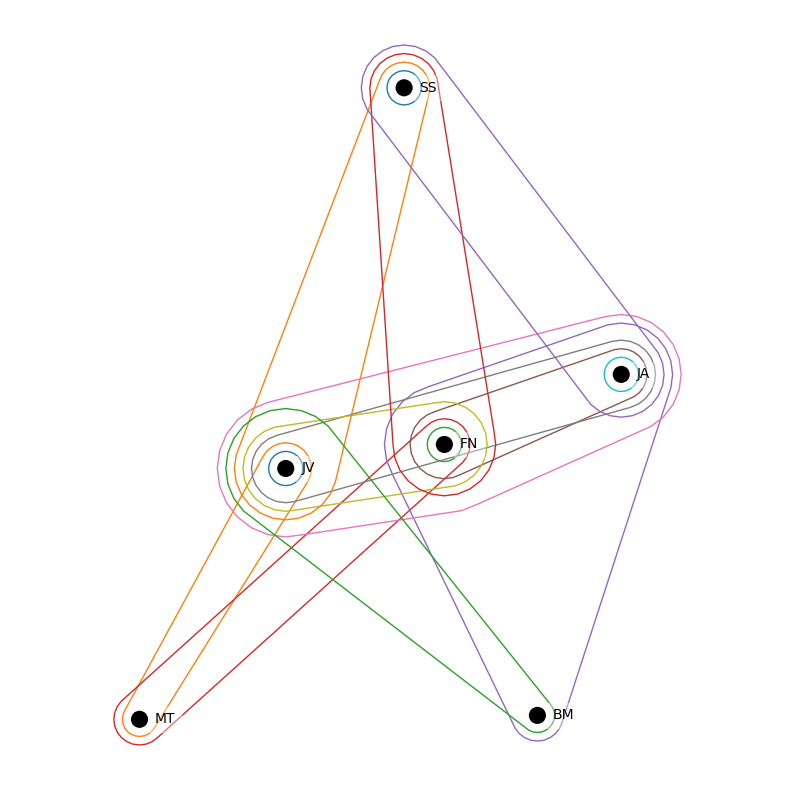

In [37]:
plt.figure(figsize=[10,10])
hnx.draw(FNJVNeighborhood.collapse_edges(),with_edge_labels=False)

While the Books Hypergraph indicated many relationships shared by FN and JV it does not indicate if FN and JV actually encountered each other alone or who they were with. The Scenes Hypergraph drills down in the hierarchy of relationships to those core scenes where actual meetings took place and who else was involved.

## Hypergraph of Scenes in Volume 1 Book 1

In [38]:
df = scenes.loc[scenes.Volume==1].loc[scenes.Book == 1]
edges = defaultdict(list)
for row in df.itertuples():
    edges[row.Chapter].append(row.Characters)
Hdf = hnx.Hypergraph(edges)

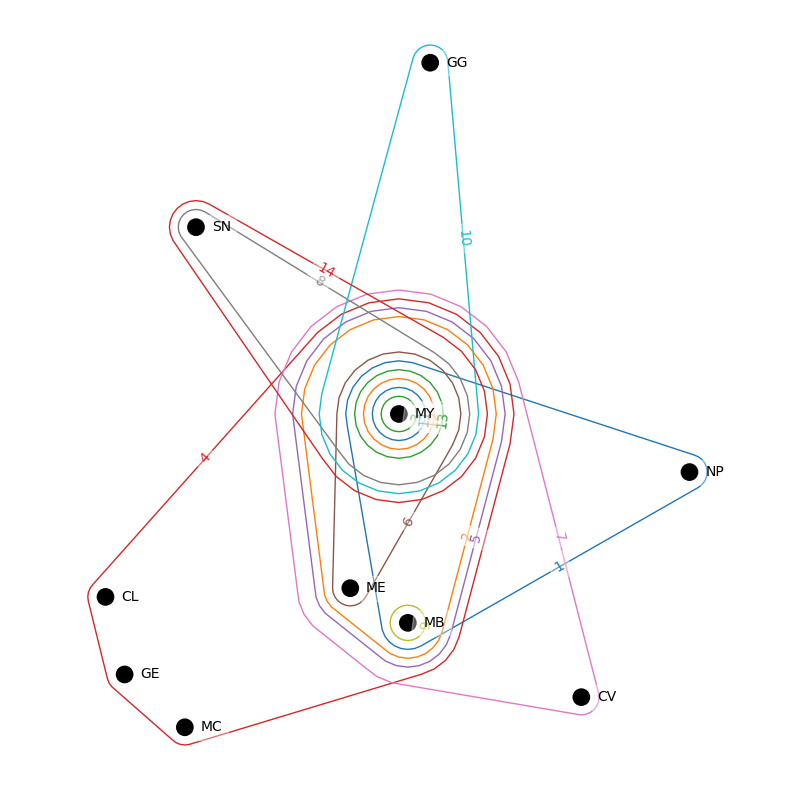

In [39]:
plt.figure(figsize=[10,10])
hnx.draw(Hdf)

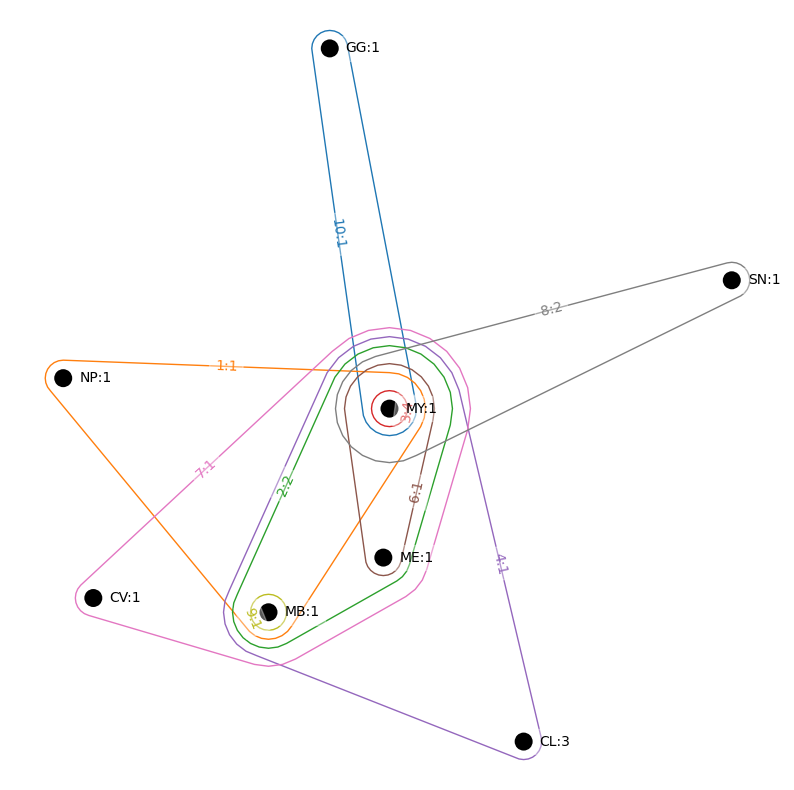

In [40]:
plt.figure(figsize=[10,10])
hnx.draw(Hdf.collapse_nodes_and_edges(use_counts=True))